In [181]:
import numpy as np
import pandas as pd
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
from bs4 import BeautifulSoup
import csv
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
##scrape from a website yayyy
source = requests.get('https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City').text
soup = BeautifulSoup(source,'lxml')
table = soup.find('table')
#write csv
csv_file = open('scrape_map_nyc.csv','w')
csv_writer = csv.writer(csv_file)
#read table
for item in table.find_all('tr'):
    list_temp=item.text.split('\n')[1:6]
    if 'Not assigned' not in list_temp:
        #print(list_temp)
        if '/' in list_temp[2]:
            list_temp[2]=list_temp[2].replace('/',',')
            csv_writer.writerow(list_temp)
        else:
            csv_writer.writerow(list_temp)
csv_file.close()

In [17]:
df_scrape = pd.read_csv('scrape_map_nyc.csv',sep=',')
df_scrape.shape

(60, 5)

In [19]:
df_scrape.head()

,Community Board(CB),Areakm2,Pop.Census2010,Pop./km2,Neighborhoods
0,Bronx CB 1,7.17,"91,497","12,761","Melrose, Mott Haven, Port Morris"
1,Bronx CB 2,5.54,"52,246","9,792","Hunts Point, Longwood"
2,Bronx CB 3,4.07,"79,762","19,598","Claremont, Concourse Village, Crotona Park, Mo..."
3,Bronx CB 4,5.28,"146,441","27,735","Concourse, Highbridge"
4,Bronx CB 5,3.55,"128,200","36,145","Fordham, Morris Heights, Mount Hope, Universit..."


In [32]:
from geopy.geocoders import Nominatim 
for i in df_scrape.index:
    address = '{}, New York, New York'.format(df_scrape.loc[i,'Neighborhoods'].split(',')[0])
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location != None:
        df_scrape.loc[i,'Latitude'] = location.latitude
        df_scrape.loc[i,'Longitude'] = location.longitude
    else:
        address = '{}, New York, New York'.format(df_scrape.loc[i,'Neighborhoods'].split(',')[1])
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        df_scrape.loc[i,'Latitude'] = location.latitude
        df_scrape.loc[i,'Longitude'] = location.longitude

In [36]:
df_scrape.to_csv('scrape_map_nyc_coordinates.csv',sep='\t',index=None)

In [137]:
df_scrape = pd.read_csv('scrape_map_nyc_coordinates.csv',sep='\t')
df_scrape.head()

,Community Board(CB),Areakm2,Pop.Census2010,Pop./km2,Neighborhoods,Latitude,Longitude
0,Bronx CB 1,7.17,"91,497","12,761","Melrose, Mott Haven, Port Morris",40.825670,-73.915242
1,Bronx CB 2,5.54,"52,246","9,792","Hunts Point, Longwood",40.812601,-73.884025
2,Bronx CB 3,4.07,"79,762","19,598","Claremont, Concourse Village, Crotona Park, Mo...",40.834167,-73.910278
3,Bronx CB 4,5.28,"146,441","27,735","Concourse, Highbridge",42.445803,-73.659611
4,Bronx CB 5,3.55,"128,200","36,145","Fordham, Morris Heights, Mount Hope, Universit...",40.861475,-73.890544


In [138]:
# create map of Toronto using latitude and longitude values
addressc_nyc = 'New York City'
latitude_nyc = 40.712728
longitude_nyc = -74.006015
map_nyc = folium.Map(location=[latitude_nyc, longitude_nyc], zoom_start=11)
# add markers to map
for lat, lng, label in zip(df_scrape['Latitude'], df_scrape['Longitude'], df_scrape['Neighborhoods']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
map_nyc

In [176]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
def exploreneighborhood(df,radius = 500):
    LIMIT = 100
    radius = radius
    CLIENT_ID = 'N3OYYH3ZCEQHHBHXBH4NASSBU0VLMVQIEI3MA2VABLFIL1S4'
    CLIENT_SECRET = 'QBGYSLTTFTTNQKCXFCHFEQHAW2HKWSP3CNY1KQQXXLU00GUZ'
    VERSION = '20200412'
    list_count=[]
    for i in df.index:
        latitude = df.loc[i,'Latitude']
        longitude = df.loc[i,'Longitude']
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
        results = requests.get(url).json()
        try:
            venues = results['response']['groups'][0]['items']  
            nearby_venues = json_normalize(venues) # flatten JSON
            # filter columns
            filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
            nearby_venues =nearby_venues.loc[:, filtered_columns]
            # filter the category for each row
            nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
            # clean columns
            nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
            ###cal
            count=0
            for i in nearby_venues['categories']:
                if i.count('Restaurant')>0:
                    count=count+1
            cal = count/len(nearby_venues['categories'])
            list_count.append(cal)
        except:
            list_count.append(0)
    df['percentage_restaurant']=list_count
    return df

In [177]:
df_new = exploreneighborhood(df_scrape)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


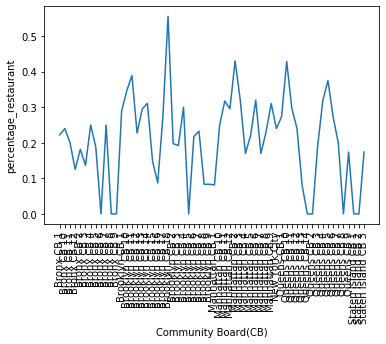

In [184]:
ax=sns.lineplot(x='Community Board(CB)',y='percentage_restaurant',data=df_new)
plt.xticks(rotation=90)
plt.show()

In [185]:
##conclusion
#Brooklyn CB 18 has the highest number of restaurants

,Community Board(CB),Areakm2,Pop.Census2010,Pop./km2,Neighborhoods,Latitude,Longitude,percentage_restaurant
0,Bronx CB 1,7.17,"91,497","12,761","Melrose, Mott Haven, Port Morris",40.825670,-73.915242,0.222222
1,Bronx CB 2,5.54,"52,246","9,792","Hunts Point, Longwood",40.812601,-73.884025,0.181818
2,Bronx CB 3,4.07,"79,762","19,598","Claremont, Concourse Village, Crotona Park, Mo...",40.834167,-73.910278,0.136364
3,Bronx CB 4,5.28,"146,441","27,735","Concourse, Highbridge",42.445803,-73.659611,0.250000
4,Bronx CB 5,3.55,"128,200","36,145","Fordham, Morris Heights, Mount Hope, Universit...",40.861475,-73.890544,0.187500
5,Bronx CB 6,4.01,"83,268","20,765","Bathgate, Belmont, East Tremont, West Farms",42.223124,-78.034451,0.000000
6,Bronx CB 7,4.84,"139,286","28,778","Bedford Park, Norwood, University Heights",40.870100,-73.885691,0.250000
7,Bronx CB 8,8.83,"101,731","11,521","Fieldston, Kingsbridge, Kingsbridge Heights, M...",40.894444,-73.903333,0.000000
8,Bronx CB 9,12.41,"172,298","13,884","Bronx River, Bruckner, Castle Hill, Clason Poi...",40.934219,-73.834864,0.000000
9,Bronx CB 10,16.76,"120,392","7,183","City Island, Co-op City, Locust Point, Pelham ...",40.847456,-73.786466,0.240000
